In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
EPOCHS = 500
INIT_LR = 1e-3
BS = 32
image_list = []
label_list = []
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/gdrive/My Drive/input'
width=256
height=256
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Late_blight ...


In [ ]:
image_size = len(image_list)
print(image_size)

2000


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

NameError: ignored

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 85, 85, 64)       

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/500
50/50 [==============================] - 34s 685ms/step - loss: 0.3378 - accuracy: 0.8912 - val_loss: 1.0587 - val_accuracy: 0.8345
Epoch 2/500
50/50 [==============================] - 32s 631ms/step - loss: 0.2915 - accuracy: 0.8998 - val_loss: 1.6622 - val_accuracy: 0.8170
Epoch 3/500
50/50 [==============================] - 31s 628ms/step - loss: 0.2836 - accuracy: 0.9036 - val_loss: 1.2227 - val_accuracy: 0.8275
Epoch 4/500
50/50 [==============================] - 31s 622ms/step - loss: 0.2694 - accuracy: 0.9049 - val_loss: 1.4915 - val_accuracy: 0.8233
Epoch 5/500
50/50 [==============================] - 31s 630ms/step - loss: 0.2623 - accuracy: 0.9076 - val_loss: 0.9369 - val_accuracy: 0.8265
Epoch 6/500
50/50 [==============================] - 31s 625ms/step - loss: 0.2309 - accuracy: 0.9163 - val_loss: 1.0211 - val_accuracy: 0.8163
Epoch 7/500
50/50 [==============================] - 31s 620ms/step - loss: 0.2073 - accuracy: 0.9240 - val_loss: 0.8330 - val_accuracy:

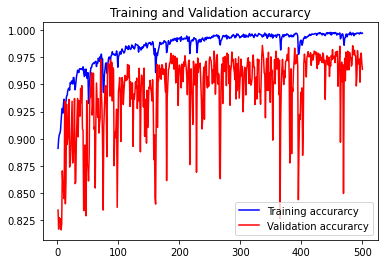

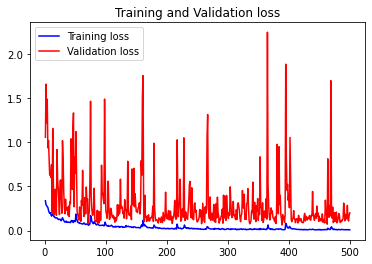

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
400/400 [==============================] - 2s 4ms/step
Test Accuracy: 96.37500047683716


In [ ]:
#Training the model
model.save('Diploma_96.375.h5')

In [ ]:
#Loading pre-trained weights
model.load_weights('Diploma_97.54999.h5')

NameError: ignored

Diploma_96.375.h5, Diploma_97.54999.h5


Tomato___healthy


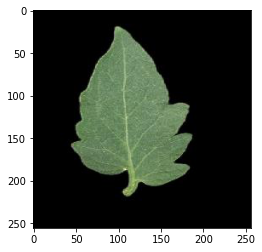

In [ ]:
# Pre-Processing test data same as train data.
img_width=256
img_height=256
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict_classes([prepare('/content/gdrive/My Drive/input/plantvillage/Tomato___healthy/4de74e9a-e32a-467a-b6fd-512a16a09d22___GH_HL Leaf 329_final_masked.jpg')])
disease=image.load_img('/content/gdrive/My Drive/input/plantvillage/Tomato___healthy/4de74e9a-e32a-467a-b6fd-512a16a09d22___GH_HL Leaf 329_final_masked.jpg')
plt.imshow(disease)
print (label_binarizer.classes_[int(result)])

Tomato___Early_blight


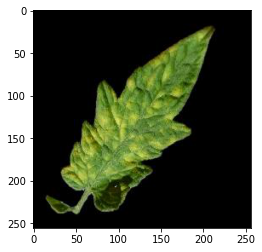

In [ ]:
result = model.predict_classes([prepare('/content/gdrive/My Drive/input/plantvillage/Tomato___Leaf_Mold/9b6483fe-95eb-464b-a73d-0cac6f777994___Crnl_L.Mold 8632_final_masked.jpg')])
disease=image.load_img('/content/gdrive/My Drive/input/plantvillage/Tomato___Leaf_Mold/9b6483fe-95eb-464b-a73d-0cac6f777994___Crnl_L.Mold 8632_final_masked.jpg')
plt.imshow(disease)
print (label_binarizer.classes_[int(result)])